In [36]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as colors
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

import numpy as np
import pandas as pd
import seaborn as snb
# from astropy.table import Table

In [2]:
import astropy.io.fits as fits
import numpy as np
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformer import TransformerReg
from train import Mastar


In [23]:
data_dir = "/data/jdli/mastar/"
photom = fits.open(data_dir + 'mastarall-gaiaedr3-extcorr-simbad-ps1-v3_1_1-v1_7_7-v1.fits')[1].data
clean_match = photom['GAIA_CLEANMATCH'] #mask of those entries with a clean match in Gaia
mask = np.where((photom['BPRPC']>-999.)&(photom['GAIA_CLEANMATCH']==1.))

goodspec = np.load(data_dir+"mastar-goodspec-v3_1_1-v1_7_7.npy", allow_pickle=True).item()

device = torch.device('cuda:1')
TOTAL_SIZE = 6000
BATCH_SIZE = 2

mastar = Mastar(photom[mask][:TOTAL_SIZE], goodspec, device=device)

train_size = int(0.75*len(mastar))
val_size = len(mastar) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mastar, [train_size, val_size])
print(len(train_dataset), len(val_dataset))


tr_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, )
val_loader = DataLoader(val_dataset,  batch_size=BATCH_SIZE, )

4500 1500


In [24]:
# # Model parameters
# dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
# n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
# n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
# n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
# input_size = 1 # The number of input variables. 1 if univariate forecasting.
# dec_seq_len = 4563 # length of input given to decoder. Can have any integer value.
# enc_seq_len = 5000 # length of input given to encoder. Can have any integer value.
# output_sequence_length = 2 # Length of the target sequence, i.e. how many time steps should your forecast
# max_seq_len = 5000

    ## Model parameters
dim_val = 64 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 4563 # length of input given to encoder. Can have any integer value.
dec_seq_len = 2 # length of input given to decoder. Can have any integer value.
output_sequence_length = 2 # Length of the target sequence, i.e. how many time steps should your forecast
max_seq_len = 4563 # What's the longest sequence the model will encounter? Used to make the positional encoder

model = TransformerReg(dim_val=dim_val, input_size=input_size, 
                       batch_first=True, dec_seq_len=dec_seq_len,
                       out_seq_len=output_sequence_length, n_decoder_layers=n_decoder_layers,
                       n_encoder_layers=n_encoder_layers, n_heads=n_heads, 
                       max_seq_len=max_seq_len).to(device)

In [25]:
model_name = "trsfm_221016a.pt"
# "trsfm_221013.pt"

model.load_state_dict(torch.load(data_dir+model_name))
model.eval()

print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    

Model's state_dict:
encoder_input_layer.weight 	 torch.Size([64, 1])
encoder_input_layer.bias 	 torch.Size([64])
decoder_input_layer.weight 	 torch.Size([64, 1])
decoder_input_layer.bias 	 torch.Size([64])
linear_mapping.weight 	 torch.Size([1, 64])
linear_mapping.bias 	 torch.Size([1])
positional_encoding_layer.pe 	 torch.Size([1, 4563, 64])
encoder.layers.0.self_attn.in_proj_weight 	 torch.Size([192, 64])
encoder.layers.0.self_attn.in_proj_bias 	 torch.Size([192])
encoder.layers.0.self_attn.out_proj.weight 	 torch.Size([64, 64])
encoder.layers.0.self_attn.out_proj.bias 	 torch.Size([64])
encoder.layers.0.linear1.weight 	 torch.Size([2048, 64])
encoder.layers.0.linear1.bias 	 torch.Size([2048])
encoder.layers.0.linear2.weight 	 torch.Size([64, 2048])
encoder.layers.0.linear2.bias 	 torch.Size([64])
encoder.layers.0.norm1.weight 	 torch.Size([64])
encoder.layers.0.norm1.bias 	 torch.Size([64])
encoder.layers.0.norm2.weight 	 torch.Size([64])
encoder.layers.0.norm2.bias 	 torch.Size([64

In [26]:
# d_model = 128
# position = torch.arange(max_seq_len).unsqueeze(1)
# div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0)/d_model))

# pe = torch.zeros(1, max_seq_len, d_model)

# pe[0, :, 0::2] = torch.sin(position * div_term)

# plt.imshow(pe.reshape(max_seq_len, dim_val).numpy(),  aspect='auto')

idx = 1

with torch.no_grad():
    src1 = model.encoder_input_layer(val_dataset[idx][0]).reshape(1, max_seq_len, dim_val)
    src2 = model.positional_encoding_layer(src1)
    src3 = model.encoder(src2)
    
    tgt1 = model.decoder_input_layer(val_dataset[idx][1]).reshape(1, dec_seq_len, dim_val)
    tgt2 = model.decoder(tgt1, src3)
    
print(src3.shape, tgt2.shape)

torch.Size([1, 4563, 64]) torch.Size([1, 2, 64])


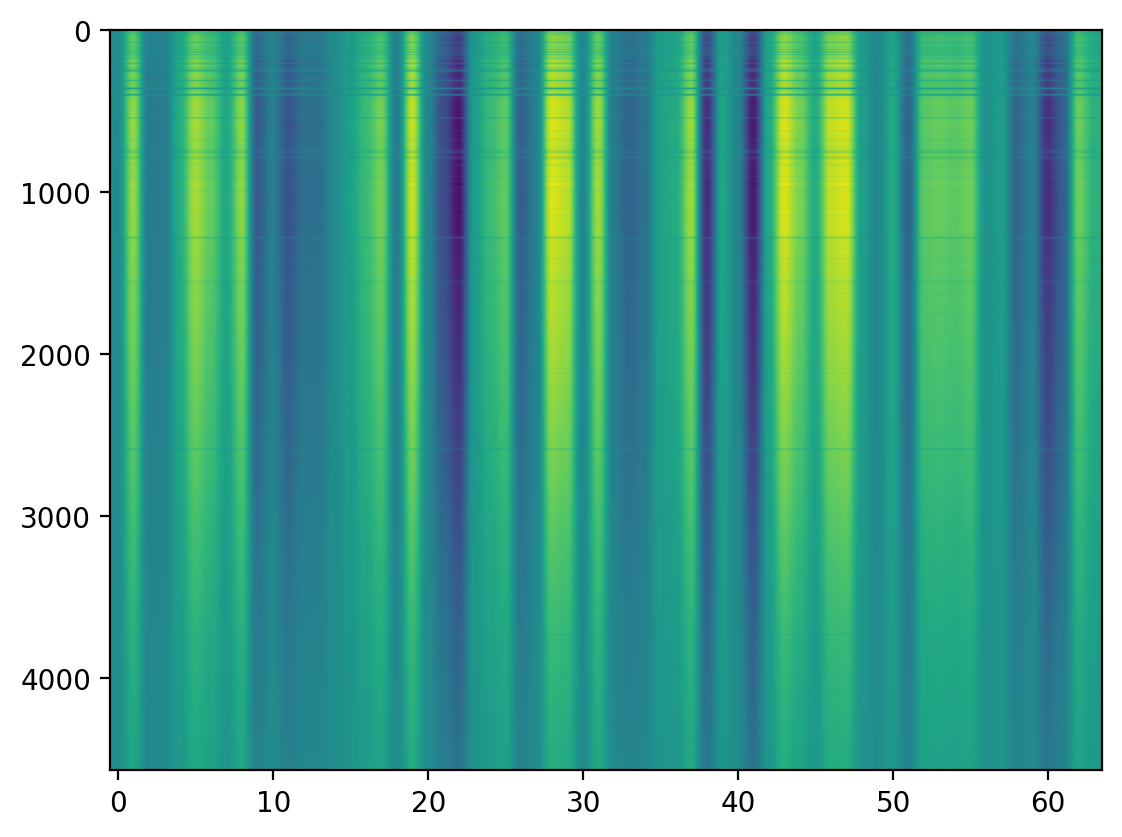

In [27]:
data = src1.reshape(max_seq_len, dim_val).cpu().numpy()

plt.imshow(data, aspect='auto')

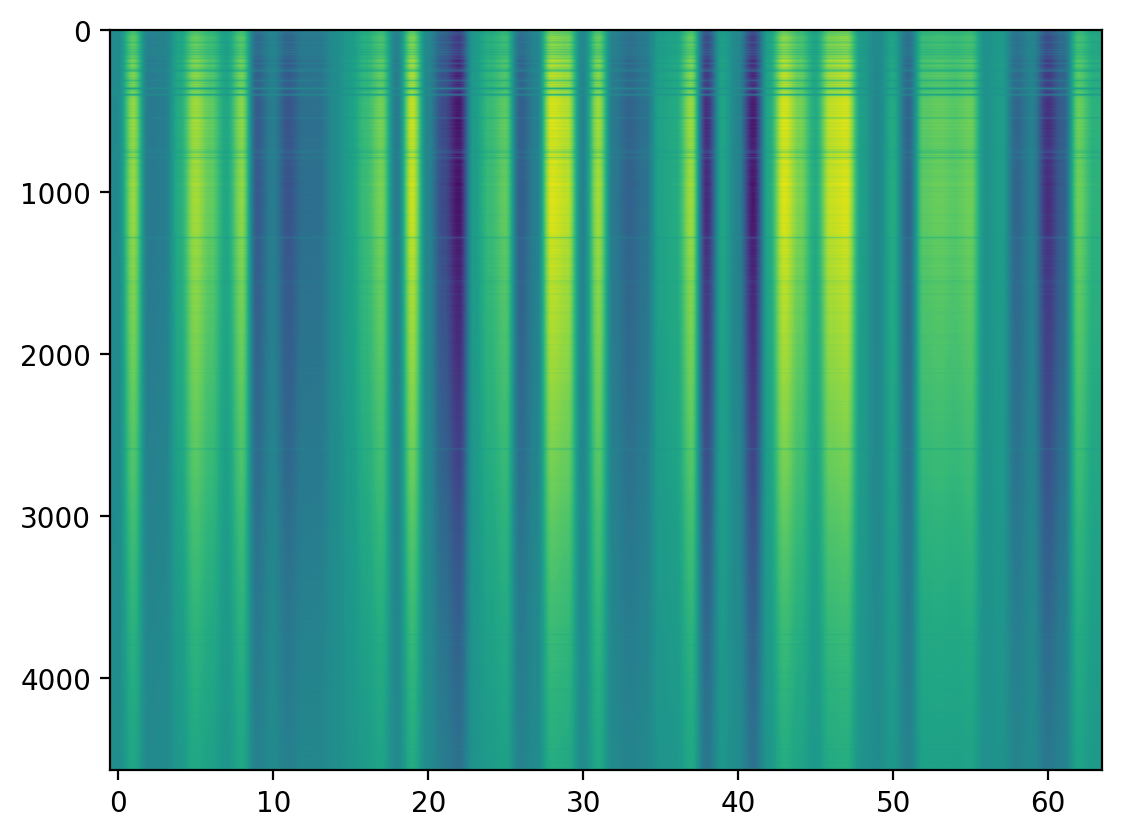

In [28]:
data = src2.reshape(max_seq_len, dim_val).cpu().numpy()

plt.imshow(data, aspect='auto')

torch.Size([1, 4563, 64]) torch.Size([1, 4563, 4563])


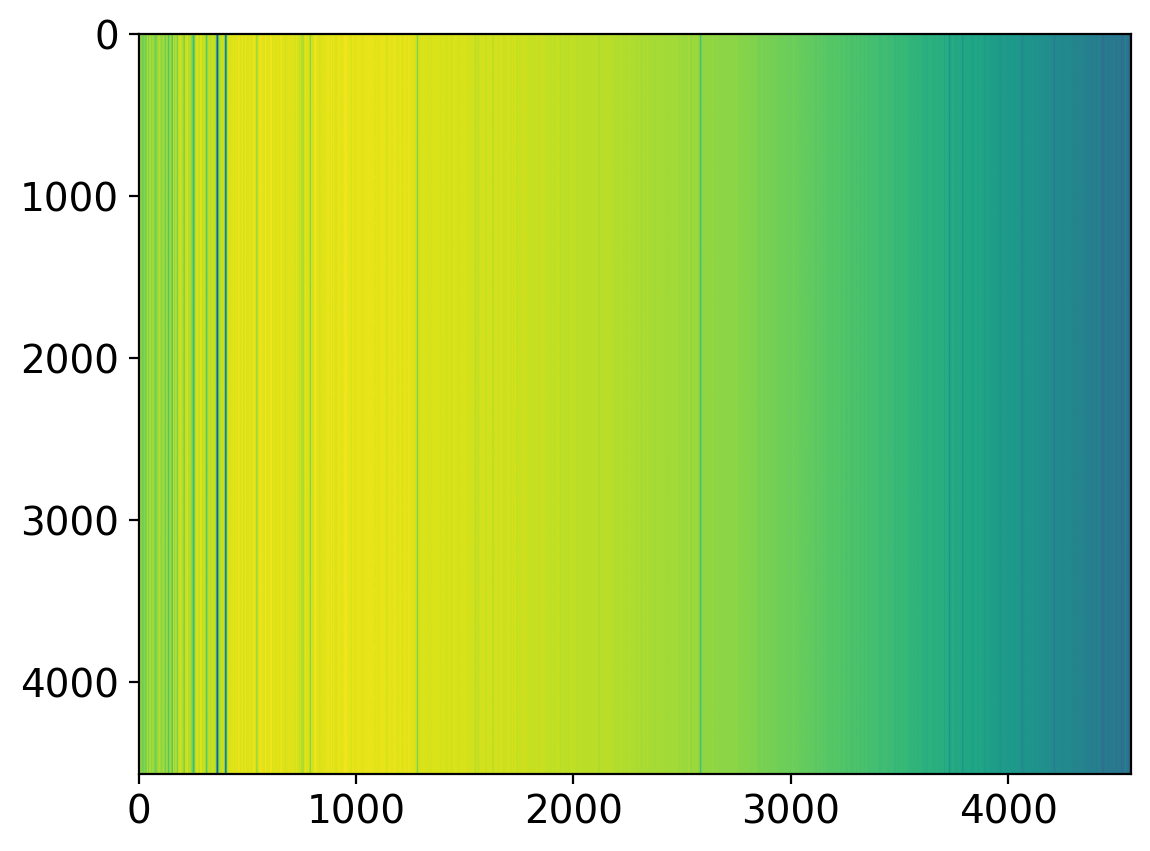

In [56]:
# attn_output, attn_output_weights = model.encoder.layers[-1].self_attn(src, src, src)
attn_output, attn_output_weights = model.encoder.layers[1].self_attn(src3, src3, src3)

print(attn_output.shape, attn_output_weights.shape)

# data = attn_output.cpu().detach().numpy().reshape(max_seq_len, dim_val)
data = attn_output_weights.cpu().detach().numpy().reshape(max_seq_len, max_seq_len)
plt.imshow(data, aspect='auto')

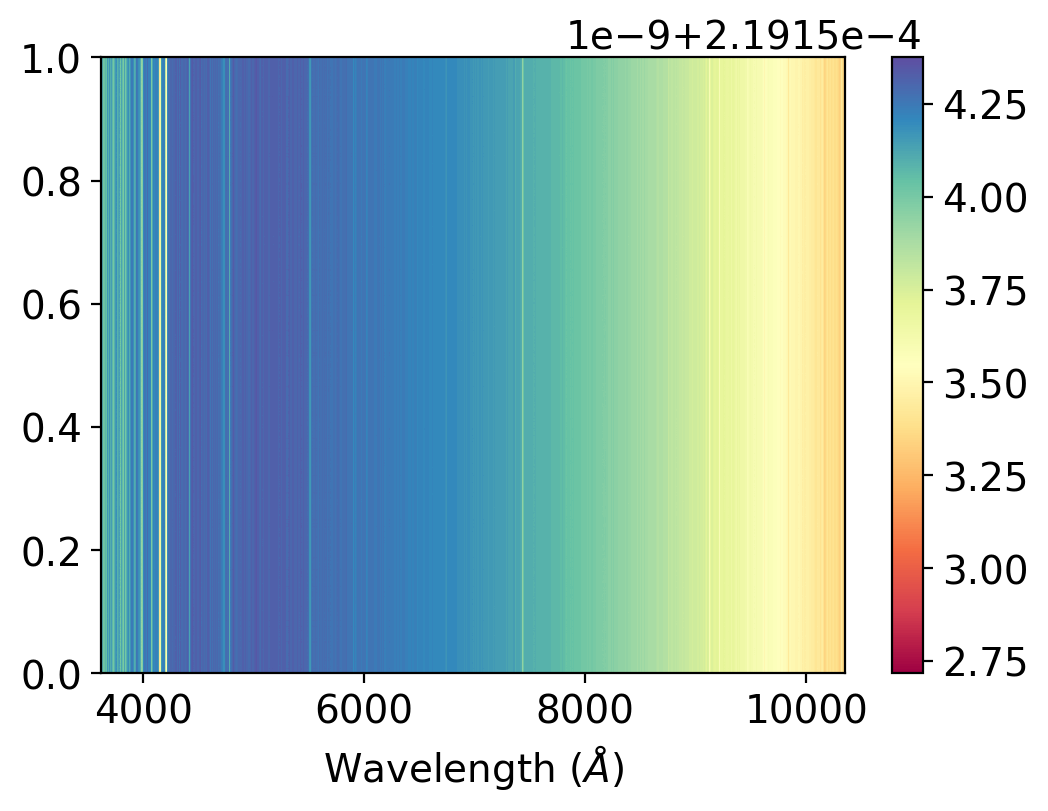

In [64]:
def draw(data, x, y, ax):
    snb.heatmap(data, xticklabels=x, square=True, yticklabels=y, 
                    norm=colors.LogNorm(),
                    cbar=False, ax=ax)
    
wave = goodspec['WAVE'][0]


fig,  ax = plt.subplots(1,1, figsize=(6,4))
# draw(data, wave, wave, ax=ax)
img = ax.imshow(data, aspect='auto',
          extent=(np.min(wave), np.max(wave), 0, 1),
          # norm=colors.LogNorm(),
          cmap='Spectral')
ax.set_xlabel(r"Wavelength ($\AA$)");
cbar = plt.colorbar(img)

In [ ]:
model.decoder.layers[0].self_attn(src3, src3, src3)

In [18]:
out_lst, y_lst = [], []


with torch.no_grad():
    for x, y in val_loader:
        output = model(x, y)
        out_lst.append(output.cpu().numpy())
        y_lst.append(y.cpu().numpy())
        del x, y, output
        
        
out_lst, y_lst = np.array(out_lst).reshape(-1,2), np.array(y_lst).reshape(-1,2)



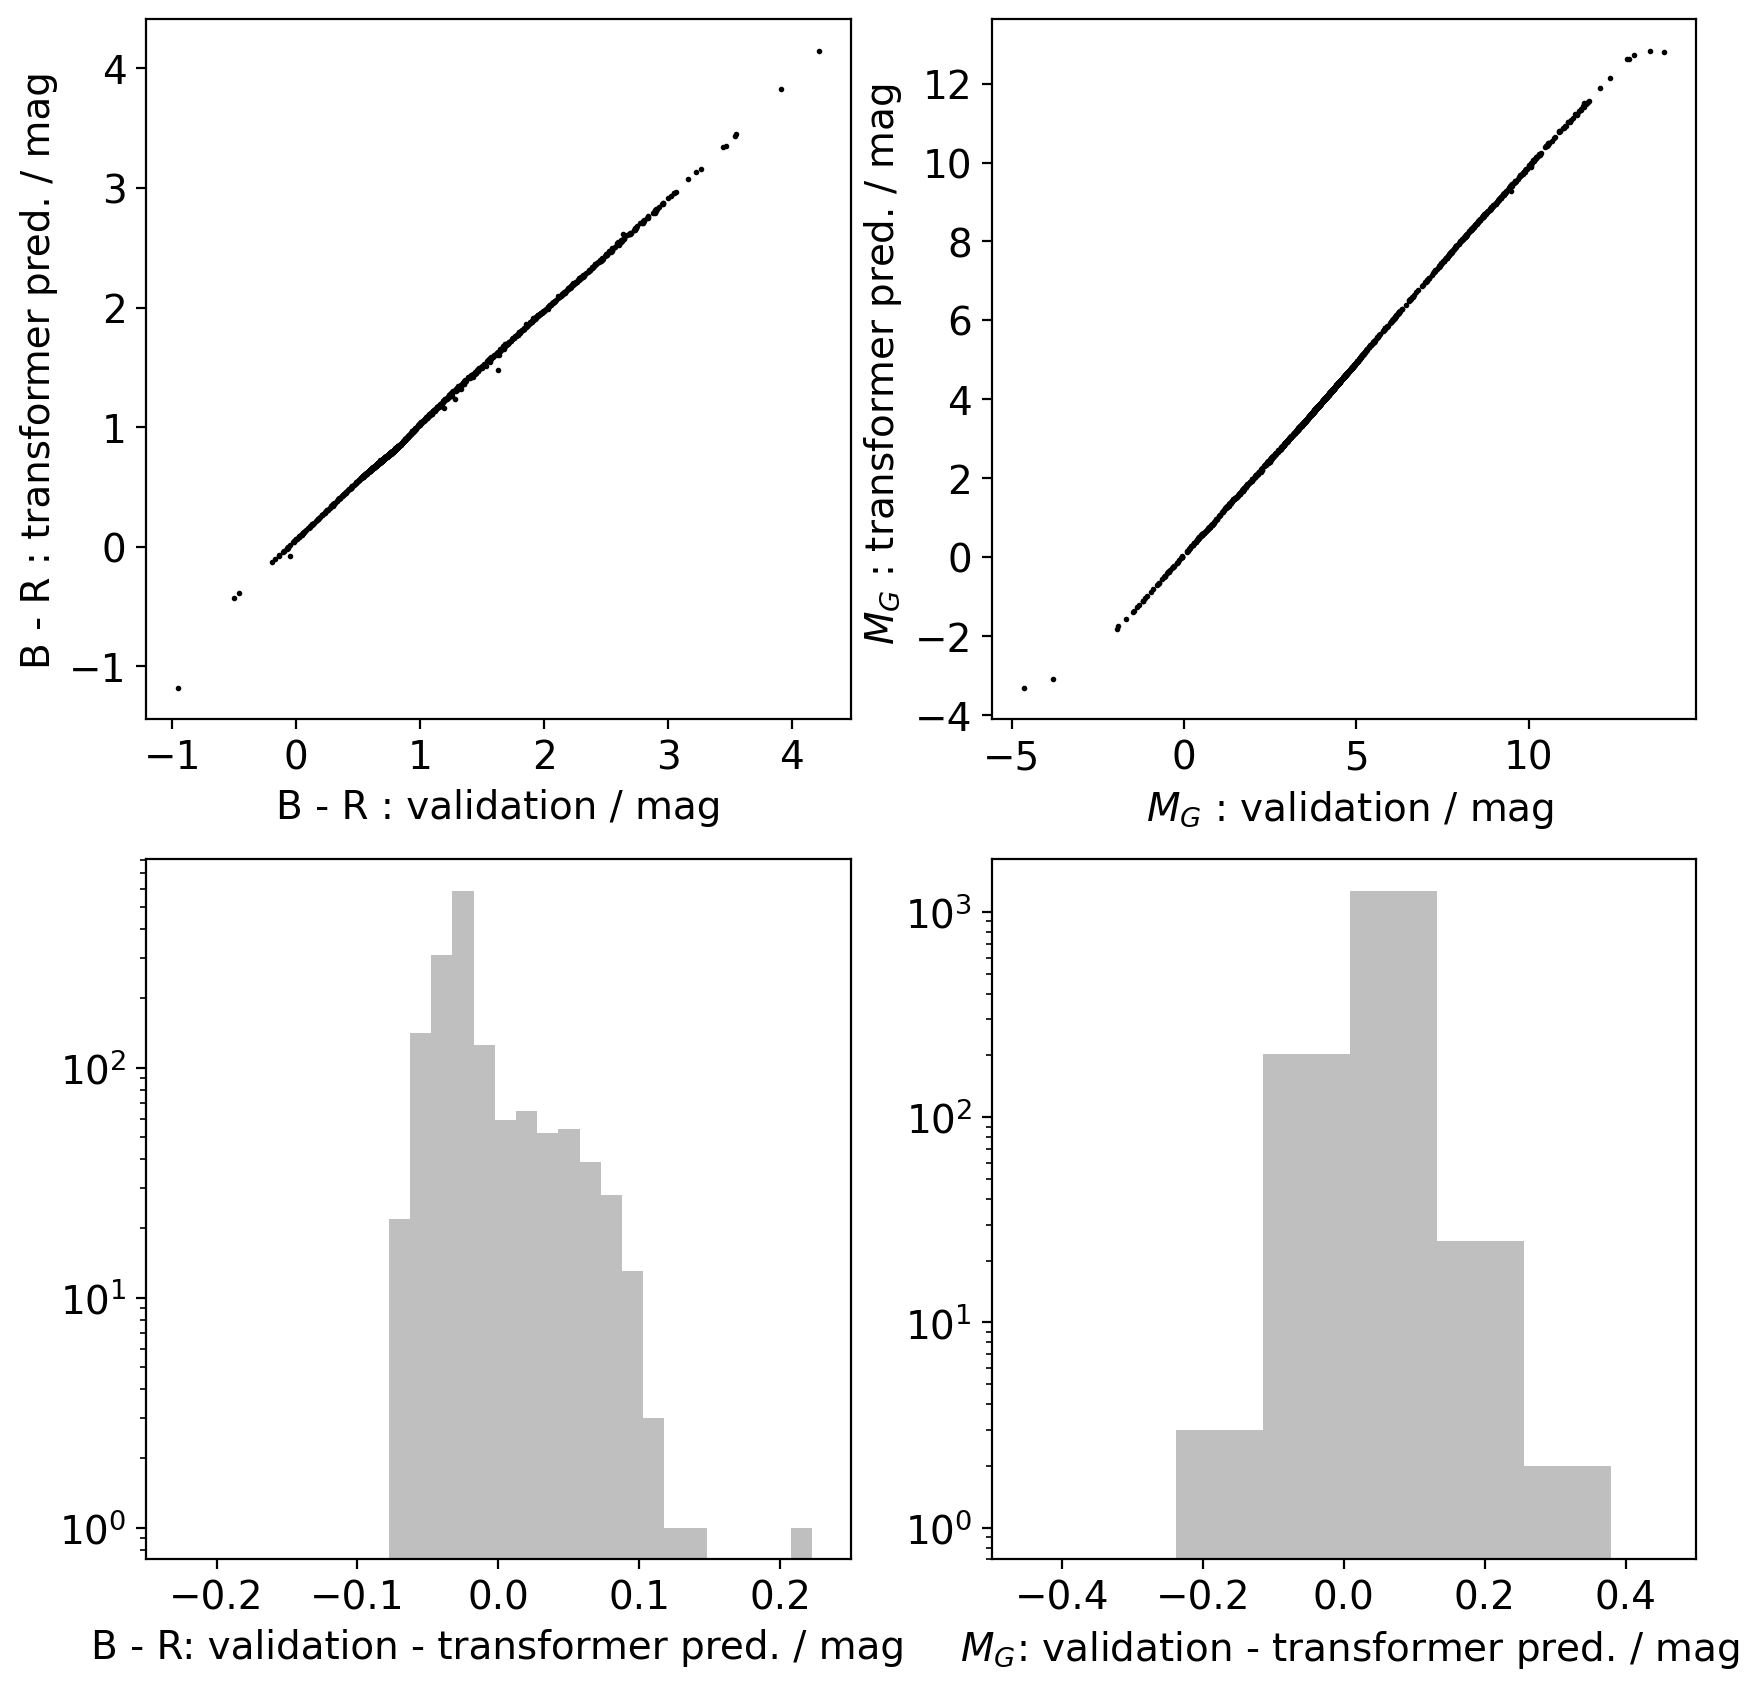

In [70]:
fig, axs = plt.subplots(2,2, figsize=(10, 10))

ax1, ax2, ax3, ax4 = axs.ravel()
ax1.scatter(y_lst[:,0], out_lst[:,0], s=1, c='k')
ax2.scatter(y_lst[:,1], out_lst[:,1], s=1, c='k')
ax1.set_xlabel("B - R : validation / mag");
ax1.set_ylabel("B - R : transformer pred. / mag");

ax2.set_xlabel(r" $M_G$ : validation / mag");
ax2.set_ylabel(r" $M_G$ : transformer pred. / mag");

ax3.hist(y_lst[:,0]-out_lst[:,0], bins=20, color='grey', alpha=0.5, density=False, log=True)
ax4.hist(y_lst[:,1]-out_lst[:,1], bins=20, color='grey', alpha=0.5, density=False, log=True)

ax3.set_xlabel("B - R: validation - transformer pred. / mag");
ax4.set_xlabel(r" $M_G$: validation - transformer pred. / mag");


ax3.set_xlim([-0.25, 0.25]);
ax4.set_xlim([-0.5, 0.5]);